In [2]:
!nvidia-smi

Tue Apr 12 15:54:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8    20W /  N/A |    767MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import json
import yaml
from tqdm import tqdm
import pickle
import librosa
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import random
import os

import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2CTCTokenizer, Wav2Vec2ForCTC, TrainingArguments, Trainer
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Code for finetuning the model

## Convert the dataset imported from the pkl files into a DatasetDict object for training on the transformers later

### magister

In [16]:
# # load the pickle data file
# with open('./pkl/magister_data_flac_16000_train.pkl', 'rb') as f:
#     df_train = pickle.load(f)

# with open('./pkl/magister_data_flac_16000_dev.pkl', 'rb') as f:
#     df_dev = pickle.load(f)
    
# with open('./pkl/magister_data_flac_16000_test.pkl', 'rb') as f:
#     df_test = pickle.load(f)
    
# # make it into a DatasetDict Object
# dataset = DatasetDict({
#     "train": Dataset.from_pandas(df_train),
#     "dev": Dataset.from_pandas(df_dev),
#     "test": Dataset.from_pandas(df_test)
# })

# # check the format of the DatasetDict
# dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1818
    })
    dev: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 360
    })
    test: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 334
    })
})

### magister v2 with proper annotations

In [4]:
# load the pickle data file
with open('./pkl/magister_data_v2_wav_16000_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('./pkl/magister_data_v2_wav_16000_dev.pkl', 'rb') as f:
    df_dev = pickle.load(f)
    
with open('./pkl/magister_data_v2_wav_16000_test.pkl', 'rb') as f:
    df_test = pickle.load(f)
    
# make it into a DatasetDict Object
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "dev": Dataset.from_pandas(df_dev),
    "test": Dataset.from_pandas(df_test)
})

# check the format of the DatasetDict
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1799
    })
    dev: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 363
    })
    test: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 334
    })
})

## Preparing the feature extractor and tokenizer

In [5]:
# extract all characters available in the train and dev datasets
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return vocab

In [7]:
# extract characters from train dataset
vocabs_train = extract_all_chars(df_train)

# extract characters from dev dataset
vocabs_dev = extract_all_chars(df_dev)

# create a union of all distinct letters in the training and the dev datasets
vocab_list = list(set(vocabs_train) | set(vocabs_dev))

# convert resulting list into an enumerated dictionary
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

# replace space with a more visible character |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

# add the [UNK], [PAD], bos and eos token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
vocab_dict["<s>"] = len(vocab_dict)
vocab_dict["</s>"] = len(vocab_dict)

# make the useless vocabs as [UNK] in the end
del vocab_dict["#"]
try:
    del vocab_dict["-"]
except KeyError:
    pass

# renumber the dictionary values to fill up the blanks
count = 0
for key, value in vocab_dict.items():
    vocab_dict[key] = count
    count += 1
    
# vocabulary is completed, now save the vocabulary as a json file
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [11]:
# PREPARING THE TOKENIZER
# use the json file to instantiate an object of the Wav2Vec2CTCTokenizer class
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", bos_token='<s>', eos_token='</s>')

# after the tokenizer object is created, the vocab.json file is not needed anymore, since the processor file will be created and the vocab.json will be there, hence can remove it
os.remove('vocab.json')

# PREPARING THE FEATURE EXTRACTOR
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

# wrap the feature extractor and tokenizer as a single Wav2VevProcessor class object
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Further preparation of the dataset after defining the processor class

In [12]:
# further preprocessing of the dataset for the transformers
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

  0%|          | 0/1799 [00:00<?, ?ex/s]

  0%|          | 0/363 [00:00<?, ?ex/s]

  0%|          | 0/334 [00:00<?, ?ex/s]

In [13]:
# check the format of the DatasetDict again with the required values needed for the training later
dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 1799
    })
    dev: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 363
    })
    test: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 334
    })
})

## Get the audio sample distribution (16k sampling)

In [14]:
# make a list to get the list of audio length of all the training data
audio_length_list = []
for idx, item in tqdm(enumerate(dataset['train'])):
    audio_length_list.append(dataset['train'][idx]['input_length'])

1799it [02:31, 11.86it/s]


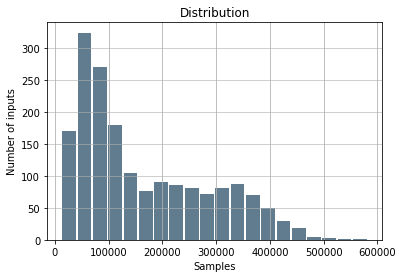

In [15]:
# get the distribution of the audio sample
data_dist = pd.Series(audio_length_list)

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Samples')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

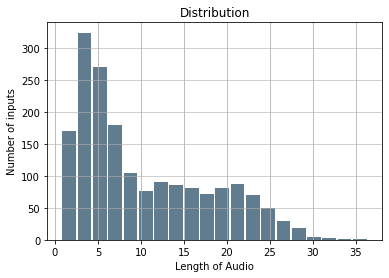

In [16]:
# get the distribution of the audio length (in 16k sample)
data_dist = pd.Series([audio_length/16000 for audio_length in audio_length_list])

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Length of Audio')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

In [17]:
# from the graph get the max sample length
MAX_SAMPLE_LENGTH = 450000

# filter out those longer duration videos (based on the histogram with the right tail minority)
dataset["train"] = dataset["train"].filter(lambda x: x < MAX_SAMPLE_LENGTH, input_columns=["input_length"])

  0%|          | 0/2 [00:00<?, ?ba/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 1778
    })
    dev: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 363
    })
    test: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 334
    })
})

## Set up Trainer class for training

In contrast to the common data collators, this data collator treats the input_values and labels differently and thus applies to separate padding functions on them (again making use of Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function. Analogous to the common data collators, the padding tokens in the labels with -100 so that those tokens are not taken into account when computing the loss.

In [19]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [20]:
# define the data collator
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
data_collator

DataCollatorCTCWithPadding(processor=Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='', vocab_size=32, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]'}), padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None)

In [21]:
# define evaluation metric
wer_metric = load_metric("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* 

In [22]:
# load pretrained wav2vec2 checkpoint - # load model from local instead of downloading from internet
model = Wav2Vec2ForCTC.from_pretrained(
    #"facebook/wav2vec2-base",
    './wav2vec2_base_model/',
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

/opt/conda/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at ./wav2vec2_base_model/ were not used when initializing Wav2Vec2ForCTC: ['project_q.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expe

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.  

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Timit dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every 400 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [23]:
# setup training arguments
training_args = TrainingArguments(
  output_dir='./ckpt',
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=10,#30
  fp16=True,
  gradient_checkpointing=True,
  save_steps=200,#500,
  eval_steps=200,#500,
  logging_steps=200,#500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
  push_to_hub=False,
)

In [24]:
# defining the training class
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["dev"],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


In [25]:
# start the finetuning
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1778
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2230


Step,Training Loss,Validation Loss,Wer
200,6.277800,3.757610,0.992441
400,2.963700,3.436249,0.992441
600,2.929200,3.096781,0.992441
800,2.445200,1.554442,0.811721
1000,1.187700,1.111075,0.406498
1200,0.712800,0.505262,0.264258
1400,0.551300,3.299031,0.252086
1600,0.421200,0.522585,0.225385
1800,0.354800,0.326894,0.192697
2000,0.289700,0.311841,0.188377


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 363
  Batch size = 8
Saving model checkpoint to ./ckpt/checkpoint-200
Configuration saved in ./ckpt/checkpoint-200/config.json
Model weights saved in ./ckpt/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./ckpt/checkpoint-200/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 363
  Batch size = 8
Saving model checkpoint to ./ckpt/checkpoint-400
Configuration saved in ./ckpt/checkpoint-400/config.json
Model weights saved in 

TrainOutput(global_step=2230, training_loss=1.6537234905054752, metrics={'train_runtime': 2636.8019, 'train_samples_per_second': 6.743, 'train_steps_per_second': 0.846, 'total_flos': 1.6692977697672673e+18, 'train_loss': 1.6537234905054752, 'epoch': 10.0})

In [27]:
# save model to local directory
trainer.save_state()
trainer.save_model('./saved_model')
# save the processor
processor.save_pretrained('./processor/')

Saving model checkpoint to ./saved_model
Configuration saved in ./saved_model/config.json
Model weights saved in ./saved_model/pytorch_model.bin
Feature extractor saved in ./saved_model/preprocessor_config.json
Feature extractor saved in ./processor/preprocessor_config.json
tokenizer config file saved in ./processor/tokenizer_config.json
Special tokens file saved in ./processor/special_tokens_map.json


## Code to resume training/finetuning

In [28]:
# load the model and processor from local
model = Wav2Vec2ForCTC.from_pretrained('./saved_model/')
processor = Wav2Vec2Processor.from_pretrained('./processor/')

loading configuration file ./saved_model/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "./wav2vec2_base_model/",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_quantizer_dropout": 0.0,
  "final_dropout"

In [29]:
# reload the dataset variable if loading the saved model
# # load the pickle data file
# with open('./pkl/magister_data_flac_16000_train.pkl', 'rb') as f:
#     df_train = pickle.load(f)

# with open('./pkl/magister_data_flac_16000_dev.pkl', 'rb') as f:
#     df_dev = pickle.load(f)
    
# with open('./pkl/magister_data_flac_16000_test.pkl', 'rb') as f:
#     df_test = pickle.load(f)
    
# # make it into a DatasetDict Object
# dataset = DatasetDict({
#     "train": Dataset.from_pandas(df_train),
#     "dev": Dataset.from_pandas(df_dev),
#     "test": Dataset.from_pandas(df_test)
# })

# load the pickle data file
with open('./pkl/magister_data_v2_wav_16000_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('./pkl/magister_data_v2_wav_16000_dev.pkl', 'rb') as f:
    df_dev = pickle.load(f)
    
with open('./pkl/magister_data_v2_wav_16000_test.pkl', 'rb') as f:
    df_test = pickle.load(f)
    
# make it into a DatasetDict Object
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "dev": Dataset.from_pandas(df_dev),
    "test": Dataset.from_pandas(df_test)
})

# further preprocessing of the dataset for the transformers
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

# from the graph get the max sample length
MAX_SAMPLE_LENGTH = 450000

# filter out those longer duration videos (based on the histogram with the right tail minority)
dataset["train"] = dataset["train"].filter(lambda x: x < MAX_SAMPLE_LENGTH, input_columns=["input_length"])

# check the format of the dataset
dataset

  0%|          | 0/1799 [00:00<?, ?ex/s]

  0%|          | 0/363 [00:00<?, ?ex/s]

  0%|          | 0/334 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 1778
    })
    dev: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 363
    })
    test: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 334
    })
})

In [32]:
## setup trainer datacollator
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch
    
# define the data collator
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
data_collator

DataCollatorCTCWithPadding(processor=Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "Wav2Vec2Processor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='./processor/', vocab_size=32, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]'}), padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None)

In [33]:
# define evaluation metric
wer_metric = load_metric("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [34]:
# setup training arguments
training_args = TrainingArguments(
  output_dir='./ckpt',
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=15,#30
  fp16=True,
  gradient_checkpointing=True,
  save_steps=200,#500,
  eval_steps=200,#500,
  logging_steps=200,#500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=3,
  push_to_hub=False,
)

# defining the training class
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["dev"],
    tokenizer=processor.feature_extractor,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [ ]:
# continue the finetuning
trainer.train(resume_from_checkpoint=True)

Loading model from ./ckpt/checkpoint-2200).
The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1778
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3345
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 9
  Continuing training from global step 2200
  Will

  0%|          | 0/193 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Wer
2400,0.275700,0.337372,0.199863
2600,0.252900,0.331623,0.183273
2800,0.215200,0.465789,0.176009
3000,0.209200,0.325613,0.179739


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 363
  Batch size = 8
Saving model checkpoint to ./ckpt/checkpoint-2400
Configuration saved in ./ckpt/checkpoint-2400/config.json
Model weights saved in ./ckpt/checkpoint-2400/pytorch_model.bin
Feature extractor saved in ./ckpt/checkpoint-2400/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 363
  Batch size = 8
Saving model checkpoint to ./ckpt/checkpoint-2600
Configuration saved in ./ckpt/checkpoint-2600/config.json
Model weights sav

In [ ]:
# save model to local directory
trainer.save_state()
trainer.save_model('./saved_model')

# save the processor
processor.save_pretrained('./processor/')

# Code to do inference

In [12]:
# load the model and processor from local
model = Wav2Vec2ForCTC.from_pretrained('./saved_model/')
processor = Wav2Vec2Processor.from_pretrained('./processor/')

loading configuration file ./saved_model/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "./saved_model/",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0.0,
 

In [4]:
# reload the dataset variable if loading the saved model
# load the pickle data file
# with open('./pkl/magister_data_flac_16000_train.pkl', 'rb') as f:
#     df_train = pickle.load(f)

# with open('./pkl/magister_data_flac_16000_dev.pkl', 'rb') as f:
#     df_dev = pickle.load(f)
    
# with open('./pkl/magister_data_flac_16000_test.pkl', 'rb') as f:
#     df_test = pickle.load(f)
    
# # make it into a DatasetDict Object
# dataset = DatasetDict({
#     "train": Dataset.from_pandas(df_train),
#     "dev": Dataset.from_pandas(df_dev),
#     "test": Dataset.from_pandas(df_test)
# })

# load the pickle data file
with open('./pkl/magister_data_v2_wav_16000_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('./pkl/magister_data_v2_wav_16000_dev.pkl', 'rb') as f:
    df_dev = pickle.load(f)
    
with open('./pkl/magister_data_v2_wav_16000_test.pkl', 'rb') as f:
    df_test = pickle.load(f)
    
# make it into a DatasetDict Object
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "dev": Dataset.from_pandas(df_dev),
    "test": Dataset.from_pandas(df_test)
})

# check the format of the DatasetDict
dataset

# further preprocessing of the dataset for the transformers
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

# from the graph get the max sample length
MAX_SAMPLE_LENGTH = 450000

# filter out those longer duration videos (based on the histogram with the right tail minority)
dataset["train"] = dataset["train"].filter(lambda x: x < MAX_SAMPLE_LENGTH, input_columns=["input_length"])

# check the format of the dataset
dataset

  0%|          | 0/1818 [00:00<?, ?ex/s]

  0%|          | 0/360 [00:00<?, ?ex/s]

  0%|          | 0/334 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 1796
    })
    dev: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 360
    })
    test: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 334
    })
})

In [13]:
# EXPERIMENTATION
def map_to_result_gpu(batch):
    model.to("cuda")
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)

    return batch

In [14]:
results_dev = dataset["dev"].map(map_to_result_gpu, remove_columns=dataset["dev"].column_names)

  0%|          | 0/360 [00:00<?, ?ex/s]

In [15]:
results_test = dataset["test"].map(map_to_result_gpu, remove_columns=dataset["test"].column_names)

  0%|          | 0/334 [00:00<?, ?ex/s]

In [16]:
results_test['text'][:5]

['OOW INCREASE ONE THREE',
 'YOUR LAST AFFIRM THE AIR LANE IS THREE THOUSAND FEET AND UP TO FOUR THOUSAND FOURTY SIX THOUSAND',
 'CONCUR SURFACE THREAT WARNING NOW RED',
 'OOW INCREASE TWO SEVEN OOW COME RIGHT THREE FOUR FIVE',
 'AGUN ALARM MISSILE AT TWO MILES AGUN ALARM MISSILE AT TWO MILES']

In [17]:
results_dev['text'][0]

'FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHOT MINUTES ONE THREE ONE FIVE O F R FIVE DECIMAL FOUR MILES OUT FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC ALFA FOUR QUEBEC ENCOUNTER MISFIRE SAFETY BEARING ZERO ZERO ZERO INTEND TO CONDUCT MISFIRE DRILL BEARING ZERO ZERO ZERO'

In [18]:
results_dev['pred_str'][0]

'FOXTROT ONE DELTA THIS IS ALPFA FOUR QUEBEC SHOT MINUTE ONE THREE ONE FIVE O F R FIVE DECIMAL FOUR OUT FOXTROT ONE DELTA THIS IS ALPFA FOUR QUEBEC ALFA FOUR QUEBEC ENCOUNTER MISFIRE SAFETY BEARING ZERO ZERO ZERO INTEND TO CONDUCT MISFIRE ZEO BEARING ZERO ZERO ZERO'

In [19]:
results_test['text'][0]

'OOW INCREASE ONE THREE'

In [20]:
results_test['pred_str'][0]

'OOW INCREASE ONE THREE'

In [21]:
# define evaluation metric
wer_metric = load_metric("wer")

In [22]:
print("Validation WER: {:.3f}".format(wer_metric.compute(predictions=results_dev["pred_str"], references=results_dev["text"])))
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_test["pred_str"], references=results_test["text"])))

Validation WER: 0.153
Test WER: 0.216


In [21]:
# ------ daniel test START ------

In [22]:
# # define evaluation metric
# wer_metric = load_metric("wer")

# def show_random_elements(dataset, num_examples=10):
#     assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
#     picks = []
#     for _ in range(num_examples):
#         pick = random.randint(0, len(dataset)-1)
#         while pick in picks:
#             pick = random.randint(0, len(dataset)-1)
#         picks.append(pick)
    
#     df = pd.DataFrame(dataset[picks])
#     display(HTML(df.to_html()))

# results_test = dataset["test"].map(map_to_result_gpu, remove_columns=dataset["test"].column_names)

In [23]:
# results_test['text'][0]

In [24]:
# results_test['pred_str'][0]

In [25]:
# print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_test["pred_str"], references=results_test["text"])))

In [26]:
# show_random_elements(results_test)

In [27]:
# ----- daniel test ENDS -----

In [23]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [24]:
show_random_elements(results_dev)

,pred_str,text
0,THIS IS PWO ROGER COMMAND PWO PERMISSION UPGRADE WEAPON EIGHT CRRECTION PEMISSION UPGRADE WEAPON READINESS STATE TWO CORRECTION A GUN READINESS STATE TWO COMMAND,THIS IS PWO ROGER COMMAND PWO PERMISSION TO UPGRADE WEAPON A CORRECTION PERMISSION TO UPGRADE WEAPON READINESS STATE TWO CORRECTION A GUN READINESS STATE TWO COMMAND
1,ROGER WEAPS PWO TRANSMIT M F R ALL ROUND TRAINING FREQUENY,ROGER WEAPS PWO TRANSMIT M F R ALL ROUND TRAINING FREQUENCY
2,FOXTROT ONE DELTA THIS IS ALPFA FOUR QUEBEC SHOT OUT,FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHOT OUT
3,AAL STATION PWO SURFACE INVESTIGATE U B [UNK] ZERO THREE ZERO BEARING [UNK] EIGHT DECIMAL CORRCTION BEARING ZERO ZERO ZERO RANGE EIGHT DECIMAL NINE,ALL STATION PWO SURFACE INVESTIGATE U B [UNK] ZERO THREE ZERO BEARING [UNK] EIGHT DECIMAL CORRECTION BEARING ZERO ZERO ZERO RANGE EIGHT DECIMAL NINE
4,THREE MILES,THREE MILES
5,SURFACE THREAT WARNING YELLOW TPS OOW PWO INFORM ONCE [UNK] READY TO HAND OVER OPS CONTROL THIS IS PWO STERING ZERO ZERO ONE SPEED TEN I HAVE OPS CONTROL OOW PWO,SURFACE THREAT WARNING YELLOW TPS OOW PWO INFORM ONCE [UNK] READY TO HAND OVER OPS CONTROL THIS IS PWO STEERING ZERO ZERO ONE SPEED TEN I HAVE OPS CONTROL OOW PWO
6,INTEND TO CONDUCT P A C ONE NAUTICAL MILES SOUTH OF STARTEX INTEND [UNK] FIRST ROUND OUT AT ONE ZERO THREE FIVE,INTEND TO CONDUCT P A C ONE NAUTICAL MILES SOUTH OF STARTEX INTEND FIRST ROUND OUT AT ONE ZERO THREE FIVE
7,AL FOXTROT ONE DELTA THIS IS ALPHA FOUR QUEBEC,ALFA FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC
8,WEAPS PWO UPGRADE A GUN READINESS STATE TWO OOOW [UNK] PWO INCREASE TWO SEVEN EW PWO CHECK WATS THE EW LION ZERO ZERO ZERO TWO,WEAPS PWO UPGRADE A GUN READINESS TO STATE TWO OOW [UNK] PWO INCREASE TWO SEVEN [UNK] EW PWO WHAT'S THE EW LINE [UNK] ZERO ZERO TWO
9,PERMISSION TO UPGRADE A GUN READINES STATE TWO WEAPS PWO UPGRADE A GUN READINES STATE TWO ALL IN PWO ACCESS WILL BE RACHING [UNK],PWO PERMISSION TO UPGRADE A GUN READINESS TO STATE TWO WEAPS PWO UPGRADE A GUN READINESS TO STATE TWO ALL IN PWO ASSESS WE WILL BE REACHING [UNK]


In [25]:
show_random_elements(results_test)

,pred_str,text
0,PWO A PROVE TRANSMIT FCR,PWO APPROVE TRANSMIT FCR
1,ENGAGE [UNK] P A C TRACK AT [UNK] THREE MILES OW PWO PWO ROGER A GUN CEASE FIRING WEAPS PWO ROGER PWOW HAUL DOWN FLAG BRAVO,ENGAGE [UNK] P A C TRACK AT [UNK] THREE MILES OOW PWO PWO ROGER A GUN CEASE FIRE WEAPS PWO ROGER PWO OOW HAUL DOWN FLAG BRAVO
2,COMMAND THIS IS PWO K RE FOR THIS INARIAL KHREE F FFSS TWO HAS READY BEN INSTRUCTED TO POSITAKE UP POSITION IN EMPIRING POSITION THREE MILES [UNK] EAST OF J R INTHIS CASE [UNK] OWN FORCE ALFA FOUR QUEBEC WILL DIRECT FOXTROT ONE DELTA TO CONDUCT DIVERSION FOR QUEBEC FOXTROT BEARING [UNK] ZERO TWO FIVE RANGE SEVEN MILES,COMMAND THIS PWO K [UNK] FOR THIS SCENARIO THREE FFS TWO HAVE ALREADY BEEN INSTRUCTED TO [UNK] TAKE UP POSITION EMPIRE POSITION THREE MILE [UNK] EAST OF JR THIS CASE [UNK] OWN FORCE ALPHA FOUR QBAT WILL DIRECT [UNK] FOXTORT ONE DETLA TO CONDUCT DIVSERION FOR QBAT FOXTROT BEARING [UNK] ZERO TWO FIVE RANGE SEVEN MILE
3,THREE ZERO ZERO TRANSMIT F C R OW COME RIGHT THREE TWO ZERO,THREE ZERO ZERO TRANSMIT F C R OOW COME RIGHT THREE TWO ZERO
4,AGUN COVER ZERO ZERO SEVEN THREE FCS CORRECTION A GUN COVER ZERO ZERO NINE FOUR,AGUN COVER ZERO ZERO SEVEN THREE CORRECTION AGUN COVER
5,ALL GUNERY POSITION SGUNERY BROADCAST POLICY SURFACE AND AIR AGUN PROVIDE MODE ALPHA LOADING BRAVO GUN PROVIDE ONE BOX H T G M PROVIDE ONE BOX TWO FIVE ZERO ROUNDS LOOKOUT ALL ROUND LOKOUT ROUTINE STANDARD FOUR FIVE ALLGUNERY POSITIONS STAND TO FCS,ALL GUNNERY POSITIONS GUNNERY BROADCAST POLICY SURFACE AND AIR AGUN PROVIDE MODE ALPHA LOADING BRAVO GUN PROVIDE ONE BOX H E I T G P M G PROVIDE ONE BOX TWO FIVE ZERO ROUNDS LOOKOUT ALL ROUND LOOKOUT ROUTINE STANDARD FOUR FIVE ALL GUNNERY POSITIONS STAND TO FCS
6,FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC A GUN ENCOUNTER STOP PAGE A TC THREE ORS INTEND TO RETURN TO BASE FOR A GUN RECTIFICATION WILL BE UNLOLDING REMAINING A GUN ROUNDS AND PROCEEDING BACK FOR PROCUEDIG BAC TO BASE FOR A GUN RECTIFACATION FOXTROT ONE DELTA OVER,FOXTROT ONE DELTA THIS IS ALFA FOUR Q QUEBEC A GUN ENCOUNTER STOPPAGE E T C THREE HOURS INTEND TO RETURN TO BASE FOR A GUN RECTIFICATION WILL BE UNLOADING REMAINING A GUN ROUNDS AND PROCEEDING BACK FOR PROCEEDING BACK TO BASE FOR A GUN RECTIFICATION FOXTROT ONE DELTA OVER
7,FOXTROT ONE DELTA THIS IS LFA FOUR QUEBEC [UNK] COMPLETED P A C FIRING [UNK] PROCEEDING FOR J R FIRING STAND BY FOR FURTHER SERP FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC FOUR YOU J HEAD [UNK]SOUTH TO ELOKATETHE POSITION UNIFORM ALFA TWO THREE THREE FOXTRT OE E,FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC [UNK] COMPLETED P A C FIRING [UNK] PROCEEDING FOR J R FIRING STAND BY FOR FURTHER SITREP FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC FOR YOU TO [UNK] HEAD [UNK] SOUTH TO ALLOCATED POSITION UNIFORM ALFA TWO THREE THREE FOXTROT ONE DELTA OVER
8,PWO ROGER OOW PWO PUT FLAG BRAVO AT DIP COM PWO CHECK [UNK] N O C INFORM AND REQUEST ED SIWER AND INDEL ROGER [UNK] COL N O SCAY AGAIN MINUTE ONE ZERO SHIP WIL COMMENCES [UNK] P A C FIRING MINUTE ONE ZERO ONE FIVE,PWO ROGER OOW PWO PUT FLAG BRAVO AT DIP COMMS PWO CHECK [UNK] N O C INFORM [UNK] OF AND REQUESTED SITREP AND INTEL ROGER [UNK] CALL N O C AGAIN MINUTES ONE ZERO SHIP WILL COMMENCES [UNK] P A C FIRING MINUTES ONE ZERO ONE FIVE
9,AL STATION TIME MINUTES TWO ZERO COMMENCES COMMS CHECK OVER THIS IS PWO LOUD AND CLEAR OVER THIS IS PWO ROGER ALL STATION THIS IS PWO MISSION BRIEF IS TO CONDUCT P A C FIRING BEFORE J R S S FIRING IN E OF TOP GUN ROUDS AFTER ONCE AFTER WE COMPLETED J R S S FOXTROT ONE DELTA WILL CONDUCT [UNK] J R S S FIRING,ALL STATION TIME MINUTUE TWO ZERO COMMENCES COMMS CHECK OVER THIS IS PWO LOUD AND CLEAR OVER THIS IS PWO ROGER ALL STATION THIS IS PWO MISSION BRIEF IS TO CONDUCT P A C FIRING BEFORE J R S S FIRING IN VIEW OF TOP GUN RULES AFTER ONCE AFTER WE COMPLETED J R S S FOXTROT ONE DELTA WILL CONDUCT HER J R S S FIRING


In [26]:
model.to("cuda")

with torch.no_grad():
    logits = model(torch.tensor(dataset["dev"][:1]["input_values"], device="cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] F O X [PAD] T T R O O O T | | O O N N E | | [PAD] D E E E L L [PAD] [PAD] T T A A [PAD] [PAD] [PAD] [PAD] | | [PAD] T H H I S S | | [PAD] [PAD] [PAD] I I I S | | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] A L L P [PAD] [PAD] F A A [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] | [PAD] [PAD] [PAD] [PAD] [PAD] F O O U U R R [PAD] [PAD] | | [PAD] [PAD] [PAD] Q U U E E [PAD] [PAD] [PAD] B [PAD] E E C [PAD] | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] S S H O O O T T | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] M I I N N U U T E E E | | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] O N N E | | T H H R E E

In [27]:
model.to("cuda")

with torch.no_grad():
    logits = model(torch.tensor(dataset["test"][:1]["input_values"], device="cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] O O O O [PAD] O [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] W W [PAD] | | | I I N N [PAD] C C R R E A A S S E E | | [PAD] [PAD] [PAD] O O N N E | | [PAD] T T H R R E E [PAD] [PAD] E E [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'